In [4]:
import numpy as np
np.set_printoptions(precision=5)

from scipy.linalg import block_diag
from scipy.integrate import ode
from scipy.optimize import minimize

import nengo
from nengo.utils.matplotlib import rasterplot
from nengo.params import Default, NumberParam
from nengo.dists import Uniform
from nengo.neurons import *
from nengo.builder.neurons import *
from nengo.dists import Uniform
from nengo.solvers import LstsqL2, NoSolver
from nengo.base import ObjView
from nengo.builder import Builder, Operator, Signal
from nengo.exceptions import BuildError
from nengo.builder.connection import build_decoders, BuiltConnection
from nengo.utils.builder import full_transform

from nengolib import Lowpass, DoubleExp
from nengolib.signal import s, z, nrmse, LinearSystem
from nengolib.synapses import ss2sim


import matplotlib.pyplot as plt

import seaborn as sns
sns.set(context='poster', style='white')
%matplotlib inline

import pandas as pd


import time
import warnings

import neuron
neuron.h.load_file('./NEURON/durstewitz/durstewitz.hoc')
neuron.h.load_file('stdrun.hoc')

1.0

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

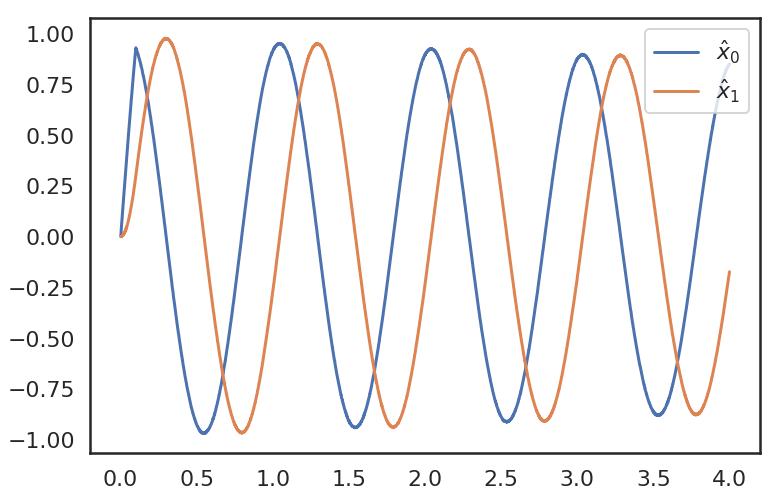

In [154]:
def go_default(t=4, freq=1, tau=0.1, dt=1e-3):
    
    w = 2*np.pi*freq
    A = [[0, -w], [w, 0]]
    A_ens = [[1, 0], [0, 1]] + tau*np.array(A)
    
    with nengo.Network(seed=0) as model:
        stim = nengo.Node(nengo.processes.Piecewise({0: [1, 0], 0.1: [0, 0]}))
        lif = nengo.Ensemble(1000, 2, neuron_type=nengo.LIF(), radius=2)
        nengo.Connection(stim, lif, synapse=None)
        nengo.Connection(lif, lif, synapse=0.1, transform=A_ens)
        p_lif = nengo.Probe(lif, synapse=0.1)
        
    with nengo.Simulator(model, seed=0, dt=dt) as sim:
        sim.run(t)
        
    fig, ax = plt.subplots(figsize=((12, 8)))
    ax.plot(sim.trange(), sim.data[p_lif][:,0], label='$\hat{x}_0$')
    ax.plot(sim.trange(), sim.data[p_lif][:,1], label='$\hat{x}_1$')
    plt.legend()
    plt.show()
    
go_default()

In [155]:
def go_oscillator(t=1, freq=1, tau=0.1, dt=1e-3, k_kick=0.6, t_kick=0.15):
    
    w = 2*np.pi*freq
    A = [[0, -w], [w, 0]]
    B = [[1], [0]]
    C = [[1, 0]]
    D = [[0]]
    A_ens = [[1, 0], [0, 1]] + tau*np.array(A)
    
    sys = LinearSystem((A, B, C, D))
    msys = ss2sim(sys, synapse=~s, dt=dt)
    
    def kick_gate(x):
        return x[:2] * (x[2] != k_kick)
    
    with nengo.Network(seed=0) as model:
        # nodes
        kick_ens = nengo.Node(lambda t: k_kick if t<=t_kick else 0)
        kick_tar = nengo.Node(lambda t: 1/dt if t<=dt else 0)
        fb_gate_lif = nengo.Ensemble(1, 3, neuron_type=nengo.Direct())
        # ensembles
        lif = nengo.Ensemble(1000, 2, neuron_type=nengo.LIF(), radius=np.sqrt(2))
        tar = nengo.Ensemble(1, 2, neuron_type=Direct())
        # kick connections
        nengo.Connection(kick_ens, lif, synapse=None, transform=msys.B)
        nengo.Connection(kick_tar, tar, synapse=~s, transform=msys.B)
        nengo.Connection(kick_ens, fb_gate_lif[2], synapse=None)
        # feedback connections
        nengo.Connection(lif, fb_gate_lif[:2], synapse=tau, transform=A_ens)
        nengo.Connection(fb_gate_lif, lif, synapse=None, function=kick_gate)
#         nengo.Connection(lif, lif, synapse=tau, transform=A_ens)
        nengo.Connection(tar, tar, synapse=~s, transform=msys.A)
        p_lif = nengo.Probe(lif, synapse=tau)
        p_tar = nengo.Probe(tar, synapse=None)
        
    with nengo.Simulator(model, seed=0, dt=dt) as sim:
        sim.run(t)
        
    fig, ax = plt.subplots(figsize=((12, 8)))
    ax.plot(sim.trange(), sim.data[p_lif][:,0], label='$\hat{x}_0$')
    ax.plot(sim.trange(), sim.data[p_lif][:,1], label='$\hat{x}_1$')
    ax.plot(sim.trange(), sim.data[p_tar][:,0], label='$x_0$')
    ax.plot(sim.trange(), sim.data[p_tar][:,1], label='$x_1$')
    plt.legend()
    plt.show()

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

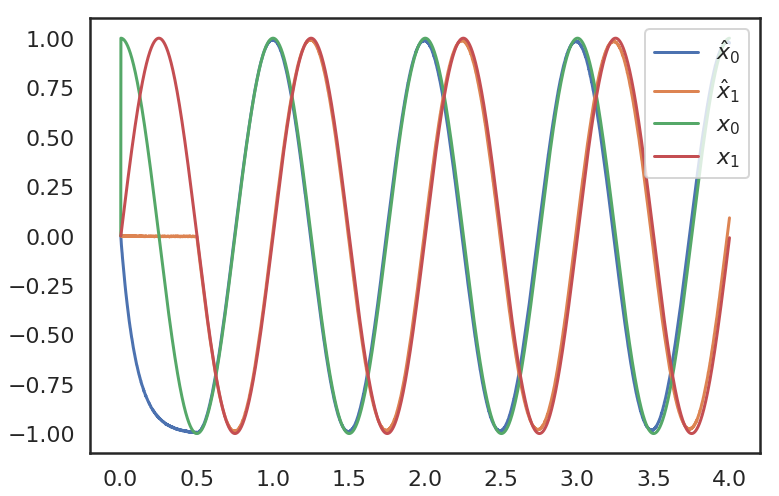

In [156]:
go_oscillator(t=4, k_kick=-1.0, t_kick=0.5)

In [225]:
def go_oracle(d, t=4, n_neurons=200, n_neurons_pre=200, supv=1,
        reg=0.1, freq=1, tau=0.1, dt=1e-3, k_kick=-1, k_damp=-10, t_kick=0.5):
    
    w = 2*np.pi*freq
    A = [[0, -w], [w, 0]]
    B = [[1], [0]]
    C = [[1, 0]]
    D = [[0]]
    A_ens = [[1, 0], [0, 1]] + tau*np.array(A)
    
    sys = LinearSystem((A, B, C, D))
    msys = ss2sim(sys, synapse=~s, dt=dt)
    
    with nengo.Network(seed=0) as model:
        # nodes
        kick_pre_u = nengo.Node(lambda t: k_kick if t<=t_kick else 0)
        damp_pre_u = nengo.Node(lambda t: k_damp if t>t_kick else 0)
        damp_pre_x = nengo.Node(lambda t: k_damp if t<t_kick else 0)
        kick_tar = nengo.Node(lambda t: 1/dt if t<=dt else 0)
        # ensembles
        pre_u = nengo.Ensemble(n_neurons_pre, 2, neuron_type=nengo.LIF(), radius=np.sqrt(2))
        pre_x = nengo.Ensemble(n_neurons_pre, 2, neuron_type=nengo.LIF(), radius=np.sqrt(2))
        ens = nengo.Ensemble(n_neurons, 2, neuron_type=nengo.LIF(), radius=np.sqrt(2))
        tar = nengo.Ensemble(1, 2, neuron_type=Direct())
        # supervisor connections
        nengo.Connection(kick_pre_u, pre_u, synapse=None, transform=msys.B)
        nengo.Connection(damp_pre_u, pre_u.neurons, synapse=None, transform=np.ones((n_neurons_pre, 1)))
        nengo.Connection(kick_tar, tar, synapse=~s, transform=msys.B)
        nengo.Connection(tar, tar, synapse=~s, transform=msys.A)
        nengo.Connection(tar, pre_x, synapse=None)
        nengo.Connection(damp_pre_x, pre_x.neurons, synapse=None, transform=np.ones((n_neurons_pre, 1)))
        if supv:
            nengo.Connection(pre_u, ens, synapse=tau)
            nengo.Connection(pre_x, ens, synapse=tau)
        else:
            nengo.Connection(pre_u, ens, synapse=tau)
            nengo.Connection(ens, ens, synapse=tau, solver=NoSolver(d))            
        # probes
        p_pre_u = nengo.Probe(pre_u, synapse=tau)
        p_pre_x = nengo.Probe(pre_x, synapse=tau)
        p_ens = nengo.Probe(ens, synapse=tau)
        p_spk = nengo.Probe(ens.neurons, synapse=None)
        p_tar = nengo.Probe(tar, synapse=None)
        
    with nengo.Simulator(model, seed=0, dt=dt) as sim:
        sim.run(t)
    
    a_ens = Lowpass(tau).filt(sim.data[p_spk][int(t_kick/dt):])
    tar = Lowpass(tau).filt(sim.data[p_tar][int(t_kick/dt):])
    times = sim.trange()[int(t_kick/dt):]
    if supv:
        d = LstsqL2(reg=reg)(a_ens, tar)[0]
    xhat = np.dot(a_ens, d)
    
    fig, ax = plt.subplots(figsize=((12, 8)))
#     ax.plot(sim.trange(), sim.data[p_pre_u][:,0], label='$\hat{preu}_0$')
#     ax.plot(sim.trange(), sim.data[p_pre_u][:,1], label='$\hat{preu}_1$')
#     ax.plot(sim.trange(), sim.data[p_pre_x][:,0], label='$\hat{prex}_0$')
#     ax.plot(sim.trange(), sim.data[p_pre_x][:,1], label='$\hat{prex}_1$')
#     ax.plot(sim.trange(), sim.data[p_ens][:,0], label='$\hat{x}_0$')
#     ax.plot(sim.trange(), sim.data[p_ens][:,1], label='$\hat{x}_1$')
#     ax.plot(sim.trange(), Lowpass(tau).filt(sim.data[p_tar][:,0]), label='$x_0$')
#     ax.plot(sim.trange(), Lowpass(tau).filt(sim.data[p_tar][:,1]), label='$x_1$')
    ax.plot(times, xhat[:,0], label='$\hat{x}_0$')
    ax.plot(times, xhat[:,1], label='$\hat{x}_1$')
    ax.plot(times, tar[:,0], label='$x_0$')
    ax.plot(times, tar[:,1], label='$x_1$')
    plt.legend()
    plt.show()
    
    return d

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

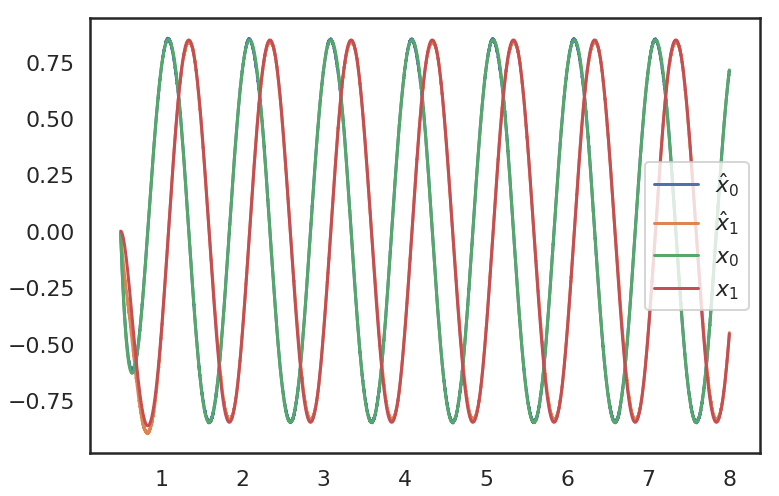

In [226]:
n_neurons = 200
d_init = np.zeros((n_neurons, 2))

d = go_oracle(d_init, n_neurons=n_neurons, t=8)

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/nengo/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

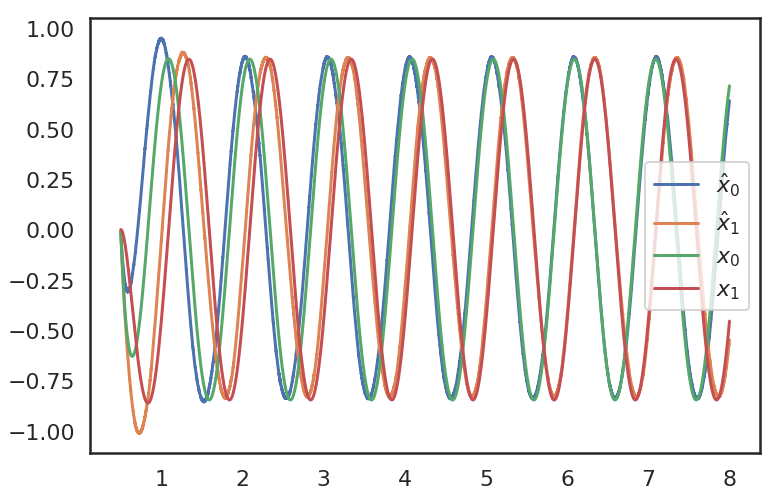

In [227]:
_ = go_oracle(d, n_neurons=n_neurons, t=8, supv=0)